### Note: Max said he would grade this
### Members: Eli Lichtblau, Muhammad Azlan, Asha Nur
# Attempting Optimal grokking through singular value normalization

## Introduction
What is grokking? [Grokking](https://arxiv.org/pdf/2201.02177.pdf) is a curious phenomenon in neural networks. It in some sense spits in the face of classic understanding of training models. Rather than describe it, as they say, a picture is worth 1,000 words.

</br>

![](./grokking.png)

Taken from the research paper linked earlier, grokking is the behavior observed on some simple problems that long past overfitting, models almost suddenly generalize. And by long past overfitting, in this example we mean *long* past, nearly 4 orders of magnitude!

## Its not actually that bad!
Okay, so 4 orders of magnitude seem completely untenable, but this was the worst case described in the paper. Lets talk about the problem discussed in the paper a bit.
</br>

### So what is the problem described in the paper? What does the paper do?
### The problem (simplified)
Modular division </br>
* Choose some prime $P$, the paper chose $P=97$
* Generate all equations of the form $a+b \equiv c$ (mod $P)$
    * $a,b,c \in \mathbb{Z}^{0\leq P}$
* This will generate $N_{data} = P*P$ equations
    * Split the data into training and validating
* Train a standard TransformerDecoder of the following structure
    * Embedding layer with positional encoding (functionally an encoder)
    * 2 Layers
        * width 128
        * 4 attention heads
* With an Adam optimizer having parameters
    * learning rate $10^{-3}$
    * weight decay $10^{-2}$ - they said 1, but pretty sure they meant $1e-2$... 1 is insane
    * $B_1 = 0.9$, $B_2=0.98$

## The problem actually described in the paper
The problem described above is a lemma of what the paper actually does. This section is not required to understand anything we did, but we would be remiss if we did not talk about the finer details of the paper. </br>
* Not just modular division
    * $a \circ b \equiv c$(mod $P$) 
    * For the following ops
        *  $a \circ b$ $ = a + b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a- b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = [a/b$ (mod $P$) for $0 \leq a \le P$, $0 \le b \le P$
        *  $a \circ b$ $ = [a/b$ (mod $P$) if $b$ is odd, otherwise $a-b$ (mod $P$)] for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + b^2$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + ab + b^2$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + ab + b^2 + a$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^3 + ab$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^3 + ab^2 + b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a * b$ for $a,b \in \mathbb{S}^5$
        *  $a \circ b$ $ = a * b * a^{-1}$ for $a,b \in \mathbb{S}^5$
        *  $a \circ b$ $ = a * b * a$ for $a,b \in \mathbb{S}^5$
* This means every input was 5 tokens
    * "a", "op", "b", "=", "c"
* Generate all equations of this form for some specific op
* Convert the 5 char arrays to 5 int arrays
* Split the data as before
* The transformer structure is unchanged
* They used a variety of optimization techniques and hyperparameter tuning
    * Minibatching and full batching
    * 10 warm up updates of mini batch size $[512, \frac{N_{trainingData}}{2}]$
    * optimization budget of $10^5$ gradient updates - I read this as steps.
    * learning rate $3e-4$, $3e-3$
    * weight decay same as before
    * Gaussian noise on weights
    * residual dropout 0.1
* They also put outliers in the dataset to see how this effected grokking

Importantly this reperesents a more full scope of what the study did. </br>
For our purposes we will just take some of their better presets as a base model.

## Results figure
![](./grokkingResults.png)
* Yes this is the worst graph in terms of labeling ever
* No the figure explanation does not help
* Below we talk about the key findings of the paper mostly ignoring this graph

## Key Results
* Adam is seemingly very important to grokking, at least momentum optimizers
* Grokking didn't happen until the singular values of weights became small
* Minibatching is superior
* Weight decay is *extremely* *extremely* important
* They didn't give precise results as far as We could tell
    * No statement that is this problem, this training data split, N optimization steps to train, M optimizations steps to grok
    * There exists some parameters such that grokking happens within an order of magnitude



## What we took from this as our base model
* The transformer model with dropout
* Adam optimizer 
    * $lr = 3e-4$
    * $weightDecay = 1e-2$
    * $B_1 = 0.9$, $B_2=0.98$
* Full batch training

Essentially this represented their best presets minus minibatching which preformed significantly better in their training. 



### Why didn't we do minibatching?
* Initally there was a plan to test the TrueGrad Adam implementation from below
    * The implementation is currently broken and do the scope of the singular value implementation we did not have time to implement it
    * Unfortunately do to compute time we are in some sense tied to this full batch training
    * We chose it for the following reasons below
* We believe on intuition that TrueGrad Adam should be much more stable
* The best way to show this is to use the "worst" case for the optimizer
* Still good presets for Adam, but a hard situation


### What we did
* Below we will reimplement the paper but to set a scene for later - what are we trying to do?
* The paper noted grokking did not happen until the singular values of the weight matrices became small
* We will implement weight matrices with a householder trick which allows us to enforce precise rules on the singular values directly. 
* We first explore this implementation on mnist and then try to use it on the problem described in the paper


## Paper re-Implementation
* Before we can add anything to the research we must first reimplement the paper


### Used libraries for complete implementation
* [pytorch](https://github.com/pytorch/pytorch)
* [Tensorflow](https://github.com/tensorflow/tensorflow) (Just for mnist dataset)
* [numpy](https://github.com/numpy/numpy)
* [TrueGrad](https://github.com/ClashLuke/TrueGrad)
* [fasth](https://github.com/AlexanderMath/fasth)
* [pandas](https://github.com/pandas-dev/pandas)
* [matplotlib](https://matplotlib.org/)
#### All neccessary imports for paper re-implementation and analysis

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from typing import Optional, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

### Preset parameters from the paper

In [2]:
P = 97
DEVICE = "cuda"
D_MODEL = 128

### Data generation

Unlike the paper we generate the smaller verison so. So our data looks as follows
* $x \in x_{train}$ x = \[10, 17, 0\]
* corresponding y = \[10, 17, (10 + 17) % p \]
* Essentially x is just y without the answer
We split the data into training and validation to the specified amount of training data.
* $x_{train}, y_{train}$ are shape (n_training_data, 3)
* $x_{test}, y_{test}$ are shape ($P*P$ - n_training_data, 3)

In [3]:
def gen_data(n_training_data: int, p: int, device: str = "cuda"):
    # generate all possible equations for mod p
    all_data = []
    for i in range(p):
        for j in range(p):
           all_data.append([i,j,(i+j)%p])
    
    all_data = np.array(all_data)
    indices = np.random.permutation(all_data.shape[0])
    train_indices = indices[:n_training_data]
    valid_indices = indices[n_training_data:]
    
    input_seq: np.ndarray = all_data.copy()
    output_seq = input_seq.copy()
    input_seq[:, -1] = 0 # don't include answers

    train_x = torch.tensor(input_seq[train_indices]).long().to(device)
    train_y = torch.tensor(output_seq[train_indices]).long().to(device)
    valid_x = torch.tensor(input_seq[valid_indices]).long().to(device)
    valid_y = torch.tensor(output_seq[valid_indices]).long().to(device)

    return (train_x, train_y), (valid_x, valid_y)

### The embedding layer
Pytorch doesn't seem to have an embedding with position encoding built in yet. It might seem overkill to implement but transformers are permutation invariant which on a symmetric problem might give us an unfair advantage.

Our implementation is standard or positional encoding - we used the [following](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/) as reference

In [ ]:
class EmbeddingWithPE(torch.nn.Embedding):
    def __init__(self, num_embeddings: int, embedding_dim: int, seq_len: int, N: int= 10_000,
            padding_idx: Optional[int] = None, max_norm: Optional[float] = None,
            norm_type: float = 2.0, scale_grad_by_freq: bool = False, sparse: bool=False,
            device: Optional[torch.device] = None, dtype: Optional[torch.dtype] = None
        ):
        super().__init__(
            num_embeddings, embedding_dim, padding_idx, max_norm, norm_type,
            scale_grad_by_freq, sparse, device, dtype
        )
       
        pe = torch.zeros((seq_len, embedding_dim))
        buf = torch.arange(embedding_dim//2)
        denom = torch.pow(N, (2*buf)/embedding_dim)
        k = torch.arange(seq_len)
        pe[k, ::2] = torch.sin(k.unsqueeze(1)/denom)
        pe[k, 1::2] = torch.cos(k.unsqueeze(1)/denom)
        # pe should not be a learnable parameter, a buffer not a parameter
        self.register_buffer("pe", pe)
             

    def forward(self, x: Tensor) -> Tensor:
        return F.embedding(
            x, self.weight, self.padding_idx, self.max_norm,
            self.norm_type, self.scale_grad_by_freq, self.sparse) + self.pe

### The Transformer Model
Won't rehash the copying of the paper but will mention a few important things.
The paper stipulated a standard decoder so this is what we built, this includes masking and layernorms.

Also important is a decoder of width N will have an output layer with N neurons. We are classifying a number that is at most P which is num_embeddings. So we add a layer such that the final layer has num_embedding $P$ outputs.

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, seq_length: int, num_embeddings: int, d_model: int, dim_feedforward: int = 2048):
        super().__init__()
        self.d_model = d_model
        self.num_embeddings = num_embeddings
        self.embed = EmbeddingWithPE(
            self.num_embeddings, self.d_model, seq_length)

        decoder_layer = torch.nn.TransformerDecoderLayer(self.d_model, nhead=4, dim_feedforward=dim_feedforward,
                                        dropout=0.1, batch_first=True, norm_first=True)
        decoder_norm = torch.nn.LayerNorm(self.d_model)

        self.decoder = torch.nn.TransformerDecoder(
            decoder_layer, num_layers=2, norm=decoder_norm)
        self.linear = torch.nn.Linear(
            self.d_model, self.num_embeddings, bias=False)
        self.mask = Parameter(
            torch.ones([seq_length, seq_length]).tril())

    def forward(self, x: Tensor) -> Tensor:
        x = self.embed(x)
        x = self.decoder.forward(x, torch.zeros_like(x), self.mask)
        return self.linear(x)

    def acc(self, prediction: Tensor, labels: Tensor):
        return (torch.argmax(prediction, dim=-2) == labels).float().mean()



### Training the model
Here we write a simple training loop to do full batch training of the model. We record the training losses and accuracie as well as the validation losses and accuracies. 

We use cross entropy because always use cross entropy.

In [ ]:
def simple_train(
    model: Transformer,
    optimizer: torch.optim.Optimizer,
    train_x: Tensor,
    train_y: Tensor, 
    valid_x: Tensor, 
    valid_y: Tensor,
    epochs: int = 10_000,
    quiet: bool = False
) -> Tuple[ Tuple[List[Tensor], List[Tensor]],  Tuple[List[Tensor], List[Tensor]]  ]:
    
    """
    Simple training method, does full batch training on transformer model
    returns (train_accs, train_losses), (valid_accs, valid_losses) 
    where each list is length epochs
    """

    model.zero_grad()
    train_losses: List[Tensor] = []
    train_accs: List[Tensor] = []
    validation_losses: List[Tensor] = []
    validation_accs: List[Tensor] = []
    for i in range(epochs):
        optimizer.zero_grad()
        output = model.forward(train_x)
        print(output.shape)
        # model.forward shape is (n_inputs, 3, 97)
        # transpose to (n_inputs, 97, 3)
        pred = output.transpose(-2, -1)
        # -1: to not drop the dim
        pred = pred[..., -1:] 
        label = train_y[:, -1:]

        loss = F.cross_entropy(pred, label)
        acc = model.acc(pred, label)
        
        # keep track of losses
        train_accs.append(acc.item())
        train_losses.append(loss.item())
        
        with torch.no_grad():
            pred_valid = model.forward(valid_x).transpose(-2, -1)[..., -1:]
            label_valid = valid_y[:, -1:]
            valid_loss = F.cross_entropy(pred_valid, label_valid)
            valid_acc = model.acc(pred_valid, label_valid)
            validation_accs.append(valid_acc.item())
            validation_losses.append(valid_loss.item())
        if i % 100 == 0 and not quiet:
            print(f"Epoch {i}: loss {loss.item():e}, training_accuracy {acc}, valid_acc {valid_acc:4f}, valid_loss: {valid_loss:4f}")
        loss.backward()
        optimizer.step()
    
    return (train_accs, train_losses), (validation_accs, validation_losses)


### Training the model on a variety of parameters

We want to generate an amount of results to compare so we do grid search on the following parameters.
* N_epochs = 15,000
* n_training_data = 800 + 100k $k \in \mathbb{Z}^{0 \le 12}$
* d_model = \[64, 128, 256\]
* dim_feedforward = \[256, 512, 1024, 2048\]
</br>

This took 1.5 *days* of compute on an rtx 2060 12GB.
We save all fully trained models to do later analysis on their singular values as well the train and validation losses and accuracies.

The naming scheme for the saved files is
* .csv or .model depending on if its the model state dict or the training accuracies losses etcetera
* \<n_training_data\>_\<d_model\>_\<dim_feedforward\>
* To not confuse anyone from earlier d_model is the same as width from the paper

In [ ]:
# For the sake of not running this biaccident we put this behind a function
def DO_NOT_RUN():
    for n_training_data in range(800, 2001, 100):
        # For consistency training data must be the same for the models of different params
        (train_x, train_y), (valid_x, valid_y) = gen_data(n_training_data, P, device=DEVICE)

        for d_model in [64, 128, 256]:
            for dim_feedforward in [256, 512, 1024, 2048]:
                model = Transformer(train_x.size(-1), P, d_model, dim_feedforward=dim_feedforward).to(DEVICE)

                optimizer = torch.optim.Adam(
                    model.parameters(),
                    lr=3e-4,
                    betas=[.9, .98],
                    weight_decay=1e-2,
                    eps=1e-8,
                    amsgrad=False,
                )
                print(f"Training model: n_train_data: {n_training_data}, d_model: {d_model} dim_feedforward: {dim_feedforward} ")
                (acc, loss), (valid_acc, valid_loss) = simple_train(model, optimizer, train_x, train_y, valid_x, valid_y, quiet=False,epochs=15_000)
                df_cols = ["Training Accuracy", "Training Loss", "Validation Accuracy", "Validation Loss"]
                df = pd.DataFrame(list(zip(acc, loss, valid_acc, valid_loss)), columns=df_cols)
                df.to_csv(f"output/{n_training_data}_{d_model}_{dim_feedforward}.csv")
                torch.save(model.state_dict(), f"output/{n_training_data}_{d_model}_{dim_feedforward}.model")

### Analysis of accuracies

First lets make a series plots as follows where <> denotes an immutable parameter
* (training_data, \<d_model=64\>, dim_feedforward)
* (training_data, \<d_model=128\>, dim_feedforward)
* (training_data, \<d_model=256\>, dim_feedforward)

So each set of plots is 13 by 4 and we can visually examine them before doing any statisical testing


KeyboardInterrupt: 

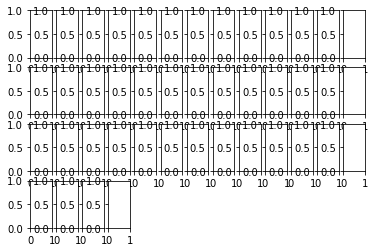

In [ ]:
dataDir = Path("./output")
count=0
for fname in sorted(os.listdir(dataDir)):
    if fname.endswith("model"):
        continue
    fullPath = dataDir/Path(fname)
    count+=1
    #print(fullPath)
fig, ax = plt.subplots(4, 13)
for row in range(4):
    for col in range(13):
        csvName = f"output/{int(800+col*100)}_64_{int(2**row * 256)}.csv"
        plt.setp(ax[row][col].get_xticklabels(), visible=False)
        if col != 0:
            plt.setp(ax[row][col].get_yticklabels(), visible=False)
        df = pd.read_csv(csvName)
fig.set_size_inches(28, 10)

### So we have a base model 
* Roughly matches the paper
* Can we do better?

### We mentioned rules on singular values
* Enforcing rules on the singular values
* (As mentioned we do not have time to explore TrueGrad Adam but we think its very worthwhile for a future study!)

### Lets explore singular values
* Relevant to the paper was that the model didn't seem to "grok" until the singular values became small
* Can we enforce this somehow?
    * Is this idea new?
    * No idea is new...

### Relevant lit.

#### Paper 1
* This [paper](https://arxiv.org/pdf/1611.06013.pdf) put a hard bound on singular values keeping them near 1
    * This preformed reasonably well 
    * But they have a problem! They have to somewhat regularly compute an svd composition to enforce the rules on their weight matrix!
        * This is extremely expensive!

#### Paper 2
* Another [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2013/01/svd_v2.pdf) use the svd to improve sparcity for generalization
    * This is (no pun) in some sense orthogonal to what we are doing, but an easily transferable task worth mentioning
* There actually isn't a ton of relevant literature on enforcing singular values (although there is a lot of research on orthogonal matrices and CNN's)
    * Why is this though?
    * We like to believe it is because methods involved computing the svd of the weights
    * this is prohibitively expensive


#### Paper 3
* But there is one very interesting paper!
* This beautiful [paper](https://arxiv.org/pdf/2009.13977.pdf) which recieved a neurips spotlight proposed SVD neural networks
* Essentially they represented each weight as its SVD decompositions ($U$, $S$, $V$) and trained them
    * This would be nice... but U and V must be orthogonal for this to make any sense
        * Regularization on gradient descent isn't enough!
        * We need math!
    * They represent $U$ and $V$ as a product of house holder matrices!
        * A householder matrix is a special orthogonal matrix which *stays orthogonal on gradient descent!!!!*
        * Limitations
            * $U$ $S$ $V$ doesn't necessarily span the most useful space when $U$ and $V$ must be householder matrices
        * Solution!
            * Any orthogonal matrix $A \in R^{(N, N)}$ can be represented by $N$ house holder matrices
        * Limitation of solution
            * Oh my god that turns the first layer of mnist into a minium of 784 matrix multiplications
        * They wrote the library mentioned at the top [fasth](https://github.com/AlexanderMath/fasth) which does the math much faster
        * Still not ideal
### Proposed ideas
* Okay we have some reasons to believe we might be able to accomplish the task
    * This looks like enforcing some "smallness" rules on our singular values
* Lets implement some layers and test on mnist


### Using householder matrices on mnist
* Mnist is great because its very learnable
#### Key limitation of householder
* You can *not* use momentum optimizers
* Householder matrices hold their properties on $SGD$ but non linear operators on the gradient break the properties
#### Householder defintion 

In [4]:
def householder(vector: Tensor):
    # assert column vector, just a good sanity check
    assert vector.shape[1] == 1
    assert len(vector.shape) == 2
    I = torch.eye(vector.shape[0])
    return I - 2*vector@vector.T/(vector.T@vector)

#### Implementation of Necessary classes
* Essentially we want a linear layer that stores the singular values
* It's useful to abstract the house holder matrices to modules
    * We can vary the number of house holder matrices later
#### Glossed over but non square weight matrices are annoying
* Defined as follows $W \in R^{(N, M)}$
    * $U \in R^{(N, N)}$, $S \in R^{(N, M)}$, $M \in R^{(M, M)}$

#### What the hell is setHouseOrthNHouseHolders!!!
* Why I'm glad you asked
* For reasons well beyond me I can't properly segment the parameters when using a parameter list
* So I write a function that outputs the houseOrth as a string with the right number of parameters
* We can then call exec on that object to set the number of householder matrices
* I'm as upset as you are about this


In [5]:
import math
from torch.nn import init
#from torch import device, dtype
# A major todo is to verify this preserves the singular values 
# It doesn't really change the "hardness" of the problem
# But my math ability is questionable
# V @ (S.T @ (U @ x.T))#
class HouseOrth(torch.nn.Module):
    def __init__(self, N: int, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        # random initialization... this could be improved
        self.U = Parameter(householder(torch.empty(N,1, **factory_kwargs).uniform_(-1/math.sqrt(N), 1/math.sqrt(N))))
        
    def forward(self, x: Tensor):
        
        return self.U @ x.T

def setHouseOrthNHouseHolders(n_householders):
    """
    Father forgive me for I hath sinned
    """
    u = [f"\t\tself.U{i} = Parameter(householder(torch.empty(N,1, **factory_kwargs).uniform_(-1/math.sqrt(N), 1/math.sqrt(N))))" for i in range(n_householders)]
    u = '\n'.join(u)
    u = u.replace("\t", " "*4)
    def helper(i):
        if i == 0:
            return "self.U0 @ x.T"
        return f"self.U{i} @ ({helper(i-1)})"
    

    s = f"""
class HouseOrth(torch.nn.Module):
    def __init__(self, N: int, device=None, dtype=None):
        factory_kwargs = {{'device': device, 'dtype': dtype}}
        super().__init__()
        # random initialization... this could be improved
{u}
    def forward(self, x: Tensor):
        
        return {helper(n_householders-1)}
    

    """
    

    return s


class LinearSVD(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        N,M = in_features, out_features
        self.in_features = in_features
        self.out_features = out_features
        self.U = HouseOrth(N, **factory_kwargs)
        # we normalize the singular values in the multiplication - smart initialization probably doesn't matter too much
        # and if it does we do not know what that would be
        self.singulars = Parameter(torch.empty(M, **factory_kwargs).uniform_(-1/math.sqrt(out_features), 1/math.sqrt(in_features)))
        self.register_buffer("S", torch.eye(N,M, **factory_kwargs)) # singulars are trainable - the matrix isn't (only the diagonal are parameters)
        self.V = HouseOrth(M, **factory_kwargs) # Whether or not this is transposed doesn't really matter - its valid either way just a diff matrix
        # copy torch.nn.Linear for what its worth here
        if bias:
            self.bias = Parameter(torch.empty((out_features,), **factory_kwargs) )
            #step = self.U()
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.V(self.U( (self.singulars*self.S).T)))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
        else:
            self.register_parameter('bias', None)

    def forward(self, x: Tensor) -> Tensor:
        if self.bias is not None:
            return self.V( ((self.singulars/self.singulars.norm() * self.S).T @ self.U(x)).T ).T + self.bias
        else:
            return self.V( ((self.singulars/self.singulars.norm() * self.S).T @ self.U(x)).T ).T 


#### Test how well this learns on minibatch mnist
* Use simple linear model
* We do minibatching for stability reasons, just makes our lives easier given slow runtime
* The models are farily usntable due in part to the terrible initialization policy

In [ ]:
import tensorflow.keras.datasets.mnist as mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = torch.tensor(x_train).cuda().reshape(x_train.shape[0], math.prod(x_train.shape[1:])).float() #/ 255 # normalize b/c uh this is prolly smart?
y_train = torch.tensor(y_train).cuda()

x_test = torch.tensor(x_test).cuda().reshape(x_test.shape[0], math.prod(x_test.shape[1:])).float()
y_test = torch.tensor(y_test).cuda()

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, useSVD=True):
        super().__init__()
        if useSVD:
            Linear = LinearSVD
        else:
            Linear = torch.nn.Linear
        self.fc1 = Linear(784, 128)
        self.fc2 = Linear(128, 128)
        self.fc3 = Linear(128, 10)
    
    def forward(self, x: Tensor):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), -1)

#### Compare linearSVD with Linear
* We cannot use Adam on HouseOrth
* We can on singulars
    * So we write a helper function which returns two optimizers one for the householder matrices which SGD and another which is Adam for all other parameters
* We do not care about generalization on mnist
    * Only inspecting training accuracies


In [15]:
def segmentHouseHolderParameters(model: torch.nn.Module):
    """
    Returns tuple[0] = HouseParameters for SGD optimizer 
    tuple[1] = All other Parameters for Adam
    """
    houseParams: List[Parameter] = []
    otherParams: List[Parameter] = []
    for module in model.modules():
        if isinstance(module, HouseOrth):
            for p in module.parameters(False): houseParams.append(p) 
        else:
            for p in module.parameters(False): otherParams.append(p)
    return houseParams, otherParams

def getOptimizers(model: torch.nn.Module, betas=[.9, .98], weight_decay=0):
    """
    Optimizers get unhappy when you give them an empty list, so we don't do that
    Just an abstraction to avoid rewriting a lot of code
    """
    hParams, nParams = segmentHouseHolderParameters(model)
    optimizers: List[torch.optim.Optimizer] = []
    if len(hParams) != 0:
        optimizers.append(torch.optim.SGD(hParams, lr=3e-3))
    if len(nParams) != 0:
        optimizers.append(torch.optim.Adam(nParams, lr=3e-4, betas=betas, weight_decay=weight_decay))
    return optimizers 



In [ ]:
def minibatchTrain(model: torch.nn.Module, optimizers: List[torch.optim.Optimizer], epochs: int = 100, batch_size: int = 1000) -> List[Tensor]:
    """
    Train the model, return list of accuracies
    the optimizers are a list because we want to be able to use different optimizers
    on different parameters in the network. 

    Our problem doesn't do minibatching - but not minibatching makes result pretty unstable so for testing we use minibatching.
    Note: I refuse to learn how to use pytorch's dataloader it confused me once 4 years ago and I took it personally.
    Note: Yes the batch size is non standard but idk divisible by 60k is nice
    """
    accuracies = []
    samples = x_train.shape[0]
    n_batches = samples // batch_size
    for i in range(epochs):
        perm = np.random.permutation(samples) # switch order every epoch generally good practice
        for batch in range(n_batches):
            x = x_train[perm[batch*batch_size:(batch+1)*batch_size]]
            y = y_train[perm[batch*batch_size:(batch+1)*batch_size]]
            for opt in optimizers: opt.zero_grad()
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            loss.backward()
            for opt in optimizers: opt.step()
        with torch.no_grad():
            acc = (torch.argmax(model(x_train), -1) == y_train).float().mean()
            accuracies.append(acc.clone().detach().cpu().numpy())
    return accuracies


#### Train a standard model fully with Adam

In [ ]:
# normal linear model
standardModel = Model(useSVD=False).cuda()
standardOpt = getOptimizers(standardModel)
standardAcc = minibatchTrain(standardModel, standardOpt)

#### Train with 1 householder matrix for each orthogonal matrix

In [ ]:
s = setHouseOrthNHouseHolders(1)
exec(s) # yes this is insane
svdModel1 = Model(useSVD=True).cuda()
svdOpt1 = getOptimizers(svdModel1)
svdAcc1 = minibatchTrain(svdModel1, svdOpt1)


#### Train with 20 householder matrix for each orthogonal matrix

In [ ]:
# svd linear model
s = setHouseOrthNHouseHolders(20)
exec(s) # yes this is insane
svdModel20 = Model(useSVD=True).cuda()
svdOpt20 = getOptimizers(svdModel20)
svdAcc20 = minibatchTrain(svdModel20, svdOpt20)


#### Train with 60 householder matrix for each orthogonal matrix

In [ ]:
# svd linear model
s = setHouseOrthNHouseHolders(60)
exec(s) # yes this is insane
svdModel60 = Model(useSVD=True).cuda()
svdOpt60 = getOptimizers(svdModel60)
svdAcc60 = minibatchTrain(svdModel60, svdOpt60)


### Oh my god it works!
* I was not expecting that!
* The model performs better with more householder matrices repersenting each orthogonal matrix
* It learns slightly slower (and is less stable (analysis would take too long in compute time))
    * But it does nearly as well as the standard model!
* We can now try to implement the actual problem

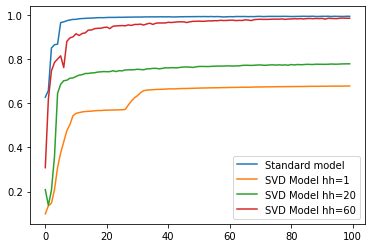

In [ ]:
fig, ax = plt.subplots()
# plotting
x = np.arange(len(standardAcc))
ax.plot(x, standardAcc, label="Standard model")
ax.plot(x, svdAcc1, label = "SVD Model hh=1")
ax.plot(x, svdAcc20, label = "SVD Model hh=20")
ax.plot(x, svdAcc60, label = "SVD Model hh=60")
ax.legend()

### Dear god we have to implement this
* Implement a full transformer under the same rules as our previous network
* To make our lives less miserable
    * We will one hot encode the inputs so we don't have to implement an embedding layer
        * If you think this is cheating we are sorry, but this is an amount of time

### Implementation difficulties
* Transformers are at most steps are 3D tensors
* This... This complicates the task

### Layernorm
* We send the non affine steps off to torch
* Implementing the affine steps is very difficult
* And not implementing them doesn't seem to be breaking
    * If this is an issue we will implement later it seems

In [7]:
import numbers


# this is a misnomer since it doesn't do bias lol
# It's also wrong: todo fix
class ElementWiseSVD(torch.nn.Module):
    def __init__(self, N: int, M: int, device=None, dtype=None):
        super().__init__()
        factory_kwargs = {'device': device, 'dtype': dtype}
        print(f"N: {N}, M: {M} ")
        self.U = HouseOrth(N, **factory_kwargs)
        self.singulars = Parameter(torch.empty(M, **factory_kwargs).uniform_(-1/math.sqrt(N), 1/math.sqrt(M)))
        self.register_buffer("S", torch.eye(N,M, **factory_kwargs)) # singulars are trainable - the matrix isn't (only the diagonal are parameters)
        self.V = HouseOrth(M, **factory_kwargs)
    
    def forward(self, x: Tensor) -> Tensor:
        # todo check if this reasonable
        return self.V( (self.singulars/self.singulars.norm() * self.S).T @ self.U.affine(x))

# Currently not doing any affine steps 
# It's bugged and it doesn't seem to be a big deal
# It introduces very high singular values classically
class LayerNormSVD(torch.nn.Module):
    def __init__(self, normalized_shape: List[int], eps: float = 1e-5, elementwise_affine: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(LayerNormSVD, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            # mypy error: incompatible types in assignment
            normalized_shape = (normalized_shape,)  # type: ignore[assignment]
        self.normalized_shape = tuple(normalized_shape)
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            if len(self.normalized_shape) > 2: raise RuntimeError("Please god")
            # Yea so we treat a 1D tensor as a unsqueeze 2D tensor this 
            # makes the problem svd-able
            special_shape = self.normalized_shape if len(normalized_shape) == 2 else tuple([normalized_shape[0], 1])
            self.svdWeight = ElementWiseSVD(special_shape[0], special_shape[1])
            #self.weight = Parameter(torch.empty(self.normalized_shape, **factory_kwargs))
            self.bias = Parameter(torch.zeros(self.normalized_shape, **factory_kwargs))
        else:
            #self.register_parameter('weight', None)
            self.register_parameter('bias', None)
    def forward(self, x: Tensor):
        nonaffinestep = F.layer_norm(x, self.normalized_shape,eps=self.eps)
        if self.elementwise_affine:
            return self.svdWeight(nonaffinestep) + self.bias
        return nonaffinestep


#### Reimplementing LinearSVD etc for 3 Tensors
* Why are we reimplementing rather than replacing earlier
    * Honestly we do not know if the math here is at all reasonable
    * Not that our confidence levels earlier are super high
    * But this is lower

#### New methods
* Split
    * Split is a method you could normally apply to a weight matrix
    * We only need to segment $U$ to be the new specified shapes
    * But we can't just emit new LinearSVD's because this makes more parameters
        * *Breaks the gradient*
    * So we have a special function that does forward_split
        * This also requires shaped_forward for houseOrth - the implementation details are fairly annoying
        * But if you do out the math it should all check out

#### The singular values aren't enforced to be norm 1
* This is mentioned later but forcing the singular values to be norm 1 basically prevented learning
* To show the implementation works we try a couple different length enforcement rules, sqrt(N) is shown in results
* This is unfortunate but it at least verifies the implementation is most likely correct


In [8]:
class HouseOrth(torch.nn.Module):
    def __init__(self, N: int, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        # random initialization... this could be improved
        self.U = Parameter(householder(torch.empty(N,1, **factory_kwargs).uniform_(-1/math.sqrt(N), 1/math.sqrt(N))))
    
    # yea this is kinda insane
    def forward(self, x: Tensor):
        return x @ self.U

    def shaped_forward(self, x: Tensor, s0: int, s1: int):
        return x @ self.U[:, s0:s1]


# yes this again... sorry
def setHouseOrthNHouseHolders(n_householders):
    """
    Father forgive me for I hath sinned
    """
    u = [f"\t\tself.U{i} = Parameter(householder(torch.empty(N,1, **factory_kwargs).uniform_(-1/math.sqrt(N), 1/math.sqrt(N))))" for i in range(n_householders)]
    u = '\n'.join(u)
    u = u.replace("\t", " "*4)
    def helper(i):
        if i == 0:
            return "x @ self.U0"
        return f"({helper(i-1)}) @ self.U{i}"
    
    def helper_shaped(i):
        if i == 0:
            return "x @ self.U0[:, s0:s1]"
        return f"({helper(i-1)}) @ self.U{i}[:,s0:s1]"

    s = f"""
class HouseOrth(torch.nn.Module):
    def __init__(self, N: int, device=None, dtype=None):
        factory_kwargs = {{'device': device, 'dtype': dtype}}
        super().__init__()
        # random initialization... this could be improved
{u}
    def forward(self, x: Tensor):
        
        return {helper(n_householders-1)}
    
    def shaped_forward(self, x: Tensor, s0: int, s1: int):
        return {helper_shaped(n_householders-1)}
    

    """
    

    return s


from typing import Union
class LinearSVD(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        N,M = in_features, out_features
        self.N, self.M = N,M
        self.in_features = in_features
        self.out_features = out_features
        self.U = HouseOrth(N, **factory_kwargs)
        # we normalize the singular values in the multiplication - smart initialization probably doesn't matter too much
        # and if it does we do not know what that would be
        self.singulars = Parameter(torch.empty(M, **factory_kwargs).uniform_(-1/math.sqrt(out_features), 1/math.sqrt(in_features)))
        self.register_buffer("S", torch.eye(N,M, **factory_kwargs)) # singulars are trainable - the matrix isn't (only the diagonal are parameters)
        self.V = HouseOrth(M, **factory_kwargs) # Whether or not this is transposed doesn't really matter - its valid either way just a diff matrix
        # copy torch.nn.Linear for what its worth here
        if bias:
            self.bias = Parameter(torch.empty((out_features,), **factory_kwargs) )
            #step = self.U()
            u = self.U.U if hasattr(self.U, "U") else self.U.U0 # householder overwrite mess
            step = u @( (self.singulars*self.S))
            step2 = self.V(step)
            fan_in, _ = init._calculate_fan_in_and_fan_out(step2)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
        else:
            self.register_parameter('bias', None)
    
    def forward_split(self, tensors: List[Tensor], shapes: List[int]) ->  List[Tensor]:
        """
        implementation of torch.split but now done on the network
        """
        #if dim != 0:
        #    raise RuntimeError("Not implemented yet, dim must equal 0")
        if isinstance(shapes, list) == False:
            raise RuntimeError("shapes must be a list... please let this be true")
        s0 = 0
        outs: List[Tensor] = []
        for s, t in zip(shapes,tensors):
            u = self.U(t)
            singular = u @ (self.singulars/self.singulars.norm() *(self.in_features**.5) * self.S)
            v = self.V.shaped_forward(singular, s0, s0+s) #.U[:, s0:s0+s]
            s0+=s
            outs.append(v)
        return outs

        
        

    def forward(self, x: Tensor) -> Tensor:
        #print(self.U.U.shape)
        #self.U(x)
        step = self.U(x)
        step2 = step @ (self.singulars/self.singulars.norm()*(self.in_features**.5)  * self.S)
        step = self.V( step2 )
        if self.bias is not None:
            return step + self.bias
        else:
            return step



### All of the following code is fundamentally copied
* We take from TrueGrad which takes from pytorch implementation I believe
* For the sake of being able to navigate the most insane jupyter notebook ever, I don't include the citations
    * But it is copied! Changing only to respect SVD linear implementation
#### To be clear that doesn't really mean this part is easy
* It is by far the worst part so far
* Just want to attribute correctly

In [9]:
def _in_projection(
        q: Tensor,
        k: Tensor,
        v: Tensor,
        svdQ: LinearSVD,
        svdK: LinearSVD,
        svdV: LinearSVD,
        b_q: Optional[Tensor] = None,
        b_k: Optional[Tensor] = None,
        b_v: Optional[Tensor] = None,
        ) -> Tuple[Tensor, Tensor, Tensor]:
    w_qShape = tuple([svdQ.in_features, svdQ.out_features])
    w_kShape = tuple([svdK.in_features, svdK.out_features])
    w_vShape = tuple([svdV.in_features, svdV.out_features])
    Eq, Ek, Ev = q.size(-1), k.size(-1), v.size(-1)
    assert w_qShape == (Eq, Eq), f"expecting query weights shape of {(Eq, Eq)}, but got {w_qShape}"
    assert w_kShape== (Eq, Ek), f"expecting key weights shape of {(Eq, Ek)}, but got {w_kShape}"
    assert w_vShape == (Eq, Ev), f"expecting value weights shape of {(Eq, Ev)}, but got {w_vShape}"
    # todo biases...
    sq = svdQ(q)
    #print("Computed svdQ")
    sk = svdK(k)
    sv = svdV(v)
    return svdQ(q), svdK(k), svdV(v)

def _in_projection_packed(
        q: Tensor,
        k: Tensor,
        v: Tensor,
        wSVD: LinearSVD,
        w: Tensor,
        b: Optional[Tensor] = None,
        ) -> List[Tensor]:
    E = q.size(-1) # this is embed size
    if k is v:
        if q is k:
            # self-attention
            #print(f"Begin k=v=q: {q.shape}, wSVD: U: {wSVD.U.U.shape} V: {wSVD.V.U.shape}")
            return wSVD.forward(q).chunk(3, -1)
        else:
            # encoder-decoder attention

            [l1, l2] = wSVD.forward_split([q, k], [E, E*2])
            
            if b is None:
                b_q = b_kv = 0 #None, 0 not none because I use + not linear method
            else:
                b_q, b_kv = torch.split(b, [E, E * 2], 0)
            return (l1 + b_q,) + (l2 + b_kv).chunk(2, -1)
    else:
        #w_q, w_k, w_v = chunk(w, 3, 0)
        [l1, l2, l3] = wSVD.forward_split([q,k,v], [E, E, E])
        if b is None:
            b_q = b_k = b_v = 0 # Can't be none cuz linear rules
        else:
            b_q, b_k, b_v = torch.chunk(b, 3, 0)
        return l1 + b_q, l2 + b_k, l3 + b_v

In [10]:



def _mha_shape_check(query: Tensor, key: Tensor, value: Tensor,
                     key_padding_mask: Optional[Tensor], attn_mask: Optional[Tensor], num_heads: int):
    # Verifies the expected shape for `query, `key`, `value`, `key_padding_mask` and `attn_mask`
    # and returns if the input is batched or not.
    # Raises an error if `query` is not 2-D (unbatched) or 3-D (batched) tensor.

    # Shape check.
    if query.dim() == 3:
        # Batched Inputs
        is_batched = True
        assert key.dim() == 3 and value.dim() == 3, \
            ("For batched (3-D) `query`, expected `key` and `value` to be 3-D"
             f" but found {key.dim()}-D and {value.dim()}-D tensors respectively")
        if key_padding_mask is not None:
            assert key_padding_mask.dim() == 2, \
                ("For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D"
                 f" but found {key_padding_mask.dim()}-D tensor instead")
        if attn_mask is not None:
            assert attn_mask.dim() in (2, 3), \
                ("For batched (3-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                 f" but found {attn_mask.dim()}-D tensor instead")
    elif query.dim() == 2:
        # Unbatched Inputs
        is_batched = False
        assert key.dim() == 2 and value.dim() == 2, \
            ("For unbatched (2-D) `query`, expected `key` and `value` to be 2-D"
             f" but found {key.dim()}-D and {value.dim()}-D tensors respectively")

        if key_padding_mask is not None:
            assert key_padding_mask.dim() == 1, \
                ("For unbatched (2-D) `query`, expected `key_padding_mask` to be `None` or 1-D"
                 f" but found {key_padding_mask.dim()}-D tensor instead")

        if attn_mask is not None:
            assert attn_mask.dim() in (2, 3), \
                ("For unbatched (2-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                 f" but found {attn_mask.dim()}-D tensor instead")
            if attn_mask.dim() == 3:
                expected_shape = (num_heads, query.shape[0], key.shape[0])
                assert attn_mask.shape == expected_shape, \
                    (f"Expected `attn_mask` shape to be {expected_shape} but got {attn_mask.shape}")
    else:
        raise AssertionError(
                f"query should be unbatched 2D or batched 3D tensor but received {query.dim()}-D query tensor")

    return is_batched

import warnings
def multi_head_attention_forward(query: Tensor, key: Tensor, value: Tensor, embed_dim_to_check: int,
                                 num_heads: int,
                                 in_proj_svd: Optional[LinearSVD], 
                                 #in_proj_weight: Optional[Tensor],
                                 in_proj_bias: Optional[Tensor], # keeping the biases sue me
                                 bias_k: Optional[Tensor],
                                 bias_v: Optional[Tensor], 
                                 add_zero_attn: bool, 
                                 dropout_p: float,
                                 out_projSVD: LinearSVD,
                                 #out_proj_weight: Tensor, 
                                 #out_proj_bias: Optional[Tensor],
                                 training: bool = True, 
                                 key_padding_mask: Optional[Tensor] = None,
                                 need_weights: bool = True, attn_mask: Optional[Tensor] = None,
                                 use_separate_proj_weight: bool = False,
                                 
                                 q_projSVD: Optional[LinearSVD] = None,
                                 k_projSVD: Optional[LinearSVD] = None,
                                 v_projSVD: Optional[LinearSVD] = None,
                                 #q_proj_weight: Optional[Tensor] = None,
                                 #k_proj_weight: Optional[Tensor] = None,
                                 #v_proj_weight: Optional[Tensor] = None,
                                 static_k: Optional[Tensor] = None,
                                 static_v: Optional[Tensor] = None, average_attn_weights: bool = True):

    #print(f"Begin multi_head_attention_forward")
    is_batched = _mha_shape_check(query, key, value, key_padding_mask, attn_mask, num_heads)
    if not is_batched:
        # unsqueeze if the input is unbatched
        query = query.unsqueeze(1)
        key = key.unsqueeze(1)
        value = value.unsqueeze(1)
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(0)
    tgt_len, bsz, embed_dim = query.shape
    src_len, _, _ = key.shape
    if key_padding_mask is not None:
        _kpm_dtype = key_padding_mask.dtype
        if _kpm_dtype != torch.bool and not torch.is_floating_point(key_padding_mask):
            raise AssertionError(
                    "only bool and floating types of key_padding_mask are supported")
    assert embed_dim == embed_dim_to_check, \
        f"was expecting embedding dimension of {embed_dim_to_check}, but got {embed_dim}"
    if isinstance(embed_dim, torch.Tensor):
        # embed_dim can be a tensor when JIT tracing
        head_dim = embed_dim.div(num_heads, rounding_mode='trunc')
    else:
        head_dim = embed_dim // num_heads
    assert head_dim * num_heads == embed_dim, f"embed_dim {embed_dim} not divisible by num_heads {num_heads}"
    if use_separate_proj_weight:
        # allow MHA to have different embedding dimensions when separate projection weights are used
        assert key.shape[:2] == value.shape[:2], \
            f"key's sequence and batch dims {key.shape[:2]} do not match value's {value.shape[:2]}"
    else:
        assert key.shape == value.shape, f"key shape {key.shape} does not match value shape {value.shape}"
    

    #print(f"Before this is different")
    # THIS IS DIFFERENT
    if not use_separate_proj_weight:
        assert in_proj_svd is not None, "use_separate_proj_weight is False but in_proj_weight is None"
        q, k, v = _in_projection_packed(query, key, value, in_proj_svd, in_proj_bias)
    else:
        assert q_projSVD is not None, "use_separate_proj_weight is True but q_proj_weight is None"
        assert k_projSVD is not None, "use_separate_proj_weight is True but k_proj_weight is None"
        assert v_projSVD is not None, "use_separate_proj_weight is True but v_proj_weight is None"
        if in_proj_bias is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = torch.chunk(in_proj_bias, 3, 0)
        q, k, v = _in_projection(query, key, value, q_projSVD, k_projSVD, v_projSVD, b_q, b_k, b_v)
    
    #print("Computed _in_projection")
    # ----- UNCHANGED ---------------
    # prep attention mask
    if attn_mask is not None:
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)
        else:
            assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                f"Only float, byte, and bool types are supported for attn_mask, not {attn_mask.dtype}"
        # ensure attn_mask's dim is 3
        if attn_mask.dim() == 2:
            correct_2d_size = (tgt_len, src_len)
            if attn_mask.shape != correct_2d_size:
                raise RuntimeError(
                        f"The shape of the 2D attn_mask is {attn_mask.shape}, but should be {correct_2d_size}.")
            attn_mask = attn_mask.unsqueeze(0)
        elif attn_mask.dim() == 3:
            correct_3d_size = (bsz * num_heads, tgt_len, src_len)
            if attn_mask.shape != correct_3d_size:
                raise RuntimeError(
                        f"The shape of the 3D attn_mask is {attn_mask.shape}, but should be {correct_3d_size}.")
        else:
            raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")
    # add bias along batch dimension (currently second)
    if bias_k is not None and bias_v is not None:
        assert static_k is None, "bias cannot be added to static key."
        assert static_v is None, "bias cannot be added to static value."
        k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
        v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
        if attn_mask is not None:
            attn_mask = F.pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = F.pad(key_padding_mask, (0, 1))
    else:
        assert bias_k is None
        assert bias_v is None

    #
    # reshape q, k, v for multihead attention and make em batch first
    #
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if static_k is None:
        k = k.contiguous().view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert static_k.size(0) == bsz * num_heads, \
            f"expecting static_k.size(0) of {bsz * num_heads}, but got {static_k.size(0)}"
        assert static_k.size(2) == head_dim, \
            f"expecting static_k.size(2) of {head_dim}, but got {static_k.size(2)}"
        k = static_k
    if static_v is None:
        v = v.contiguous().view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert static_v.size(0) == bsz * num_heads, \
            f"expecting static_v.size(0) of {bsz * num_heads}, but got {static_v.size(0)}"
        assert static_v.size(2) == head_dim, \
            f"expecting static_v.size(2) of {head_dim}, but got {static_v.size(2)}"
        v = static_v
    
    # add zero attention along batch dimension (now first)
    if add_zero_attn:
        zero_attn_shape = (bsz * num_heads, 1, head_dim)
        k = torch.cat([k, torch.zeros(zero_attn_shape, dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros(zero_attn_shape, dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = F.pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = F.pad(key_padding_mask, (0, 1))

    # update source sequence length after adjustments
    src_len = k.size(1)

    # merge key padding and attention masks
    if key_padding_mask is not None:
        assert key_padding_mask.shape == (bsz, src_len), \
            f"expecting key_padding_mask shape of {(bsz, src_len)}, but got {key_padding_mask.shape}"
        key_padding_mask = key_padding_mask.view(bsz, 1, 1, src_len). \
            expand(-1, num_heads, -1, -1).reshape(bsz * num_heads, 1, src_len)
        if attn_mask is None:
            attn_mask = key_padding_mask
        elif attn_mask.dtype == torch.bool:
            attn_mask = attn_mask.logical_or(key_padding_mask)
        else:
            attn_mask = attn_mask.masked_fill(key_padding_mask, float("-inf"))
    
    # convert mask to float
    if attn_mask is not None and attn_mask.dtype == torch.bool:
        new_attn_mask = torch.zeros_like(attn_mask, dtype=q.dtype)
        new_attn_mask.masked_fill_(attn_mask, float("-inf"))
        attn_mask = new_attn_mask

    # adjust dropout probability
    if not training:
        dropout_p = 0.0
    
    #
    # (deep breath) calculate attention and out projection
    #

    B, Nt, E = q.shape
    q_scaled = q / math.sqrt(E)
    if attn_mask is not None:
        attn_output_weights = torch.baddbmm(attn_mask, q_scaled, k.transpose(-2, -1))
    else:
        attn_output_weights = torch.bmm(q_scaled, k.transpose(-2, -1))
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    if dropout_p > 0.0:
        attn_output_weights = F.dropout(attn_output_weights, p=dropout_p)

    attn_output = torch.bmm(attn_output_weights, v)

    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len * bsz, embed_dim)
    # ------------- FINISH UNCHANGED -----------------------
    # THIS IS CHANGED
    attn_output = out_projSVD.forward(attn_output) #+ out_proj_bias #linear(attn_output, out_proj_weight, out_proj_bias)
    # FINISH CHANGE
    attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))

    if need_weights:
        # optionally average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        if average_attn_weights:
            attn_output_weights = attn_output_weights.sum(dim=1) / num_heads

        if not is_batched:
            # squeeze the output if input was unbatched
            attn_output = attn_output.squeeze(1)
            attn_output_weights = attn_output_weights.squeeze(0)
        return attn_output, attn_output_weights
    else:
        if not is_batched:
            # squeeze the output if input was unbatched
            attn_output = attn_output.squeeze(1)
        return attn_output, None
    


    



In [11]:
from typing import Union, Callable

class MultiheadAttentionSVD(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False,
                 kdim=None, vdim=None, batch_first=False, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(MultiheadAttentionSVD, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if not self._qkv_same_embed_dim:
            # Parameters are backwards with respect to weight matrices
            self.q_proj_weight = LinearSVD(embed_dim, embed_dim, **factory_kwargs) #Parameter(torch.empty((embed_dim, embed_dim), **factory_kwargs))
            self.k_proj_weight = LinearSVD(self.kdim, embed_dim, **factory_kwargs) #Parameter(torch.empty((embed_dim, self.kdim), **factory_kwargs))
            self.v_proj_weight = LinearSVD(self.vdim, embed_dim, **factory_kwargs) #Parameter(torch.empty((embed_dim, self.vdim), **factory_kwargs))
            self.register_parameter('in_projSVD', None)
        else:
            self.in_projSVD = LinearSVD(embed_dim, 3*embed_dim) #Parameter(torch.empty((3 * embed_dim, embed_dim), **factory_kwargs))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)
        
        if bias:
            # init to 0
            self.in_proj_bias = Parameter(torch.zeros(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter('in_proj_bias', None)
        
        self.out_proj = LinearSVD(embed_dim, embed_dim, bias=bias, **factory_kwargs)

        if add_bias_kv:
            self.bias_k = Parameter(init.xavier_normal_(torch.empty((1, 1, embed_dim), **factory_kwargs)))
            self.bias_v = Parameter(init.xavier_normal_(torch.empty((1, 1, embed_dim), **factory_kwargs)))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn
    
    def forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True, attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True) -> Tuple[Tensor, Optional[Tensor]]:
        # We assume no fast path for sanity
        is_batched = query.dim() == 3
        if self.batch_first and is_batched:
            # make sure that the transpose op does not affect the "is" property
            if key is value:
                if query is key:
                    query = key = value = query.transpose(1, 0)
                else:
                    query, key = [x.transpose(1, 0) for x in (query, key)]
                    value = key
            else:
                query, key, value = [x.transpose(1, 0) for x in (query, key, value)]
        
        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_projSVD, self.in_proj_bias, self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj, training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_projSVD=self.q_proj_weight, k_projSVD=self.k_proj_weight,
                v_projSVD=self.v_proj_weight, average_attn_weights=average_attn_weights
            )
        else:
            attn_output, attn_output_weights = multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_projSVD, self.in_proj_bias, self.bias_k, self.bias_v,
                self.add_zero_attn, self.dropout, self.out_proj, training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, average_attn_weights=average_attn_weights
            )
        if self.batch_first and is_batched:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights



class TransformerDecoderLayerSVD(torch.nn.Module):
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerDecoderLayerSVD, self).__init__()
        self.self_attn = MultiheadAttentionSVD(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                            **factory_kwargs)
        self.multihead_attn = MultiheadAttentionSVD(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                                 **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = LinearSVD(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = LinearSVD(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = LayerNormSVD(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = LayerNormSVD(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm3 = LayerNormSVD(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.dropout3 = torch.nn.Dropout(dropout)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            raise RuntimeError("Dont do this")
        else:
            self.activation = activation
    
    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerDecoderLayerSVD, self).__setstate__(state)
    
    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None, memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:

        x = tgt
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask)
            x = x + self._mha_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask)
            x = x + self._ff_block(self.norm3(x))
        else:
            x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask))
            x = self.norm2(x + self._mha_block(x, memory, memory_mask, memory_key_padding_mask))
            x = self.norm3(x + self._ff_block(x))

        return x
    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        #print(f"Begin _sa_block")
        x = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)[0]
        #print(f"Finish _sa_block")
        return self.dropout1(x)

    # multihead attention block
    def _mha_block(self, x: Tensor, mem: Tensor,
                   attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x = self.multihead_attn.forward(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                need_weights=False)[0]
        return self.dropout2(x)

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)

import copy
def _get_clones(module, N):
    return torch.nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# just useful for mnetal segmentation - doesn't really need to be copied
class TransformerDecoderSVD(torch.nn.Module):
    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoderSVD, self).__init__()
        self.layers: List[TransformerDecoderLayerSVD] = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        
        output = tgt

        for mod in self.layers:
            output = mod.forward(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output



In [12]:
class TransformerSVD(torch.nn.Module):
    def __init__(self, seq_length: int, num_embeddings: int, d_model: int, dim_feedforward: int = 2048):
        super().__init__()
        self.d_model = d_model
        self.num_embeddings = num_embeddings
        #self.embed = EmbeddingWithPE(
        #    self.num_embeddings, self.d_model, seq_length)

        decoder_layer = TransformerDecoderLayerSVD(self.d_model, nhead=4, dim_feedforward=dim_feedforward,
                                        dropout=0.1, batch_first=True, norm_first=True)
        decoder_norm = LayerNormSVD(self.d_model)

        self.decoder = TransformerDecoderSVD(
            decoder_layer, num_layers=2, norm=decoder_norm)
        self.linear = LinearSVD(
            self.d_model, self.num_embeddings, bias=False)
        self.mask = Parameter(
            torch.ones([seq_length, seq_length]).tril())

    def forward(self, x: Tensor) -> Tensor:
        #x = self.embed(x)
        x = self.decoder.forward(x, torch.zeros_like(x), self.mask)
        return self.linear(x)

    def acc(self, prediction: Tensor, labels: Tensor):
        return (torch.argmax(prediction, dim=-2) == labels).float().mean()

(train_x, train_y), (valid_x, valid_y) = gen_data(1300, P, device=DEVICE)

def to_cat(x):
    return F.one_hot(x, 128).float()


s = setHouseOrthNHouseHolders(30) # lol I run out of memory
exec(s) # insane still!!

model = TransformerSVD(train_x.size(-1), P, 128).cuda()



opt = getOptimizers(model)
train_x = to_cat(train_x)
valid_x = to_cat(valid_x)
losses = []
train_accs = []
val_accs = []
for i in range(15_000):
    opt[0].zero_grad()
    opt[1].zero_grad()
    output = model.forward(train_x)
    pred = output.transpose(-2, -1)
    pred = pred[..., -1:] 
    label = train_y[:, -1:]

    loss = F.cross_entropy(pred, label)
    losses.append(loss.item())
    acc = model.acc(pred, label)
    train_accs.append(acc.item())
    with torch.no_grad():
        pred_valid = model.forward(valid_x).transpose(-2, -1)[..., -1:]
        label_valid = valid_y[:, -1:]
        valid_acc = model.acc(pred_valid, label_valid)
        val_accs.append(valid_acc.item())
    if i % 2 == 0:
            print(f"Epoch {i}: loss {loss.item():e}, training_accuracy {acc}, valid_acc: {valid_acc}")
    loss.backward()
    opt[0].step()
    opt[1].step()
        



Epoch 0: loss 5.316059e+00, training_accuracy 0.011538461782038212, valid_acc: 0.00986558198928833
Epoch 2: loss 4.836143e+00, training_accuracy 0.01846153847873211, valid_acc: 0.008879023604094982
Epoch 4: loss 4.697193e+00, training_accuracy 0.013846153393387794, valid_acc: 0.009125662967562675
Epoch 6: loss 4.611234e+00, training_accuracy 0.016153845936059952, valid_acc: 0.011838697828352451
Epoch 8: loss 4.588040e+00, training_accuracy 0.01923076994717121, valid_acc: 0.009372302331030369
Epoch 10: loss 4.582402e+00, training_accuracy 0.020769231021404266, valid_acc: 0.008755703456699848
Epoch 12: loss 4.537904e+00, training_accuracy 0.023846153169870377, valid_acc: 0.009002342820167542
Epoch 14: loss 4.527625e+00, training_accuracy 0.023076923564076424, valid_acc: 0.007892465218901634
Epoch 16: loss 4.482225e+00, training_accuracy 0.023076923564076424, valid_acc: 0.008879023604094982
Epoch 18: loss 4.463223e+00, training_accuracy 0.02846153825521469, valid_acc: 0.007892465218901634

KeyboardInterrupt: 

#### Trained with singular values normed to sqrt(N) for 500 epochs, n_householders=30, ntraining=1,000
* It can learn!
    * Implementation probably correct
* It isn't grokking better
* Note: this is from a saved model trained on these parameters, the model is 10GB in size
    * Therefore I do not want to "load" it or upload it, it will crash so you'll just have to believe us here
    * We wouldn't lie about such dissapointing results
    * We stopped very early in trainaing because it just takes so long

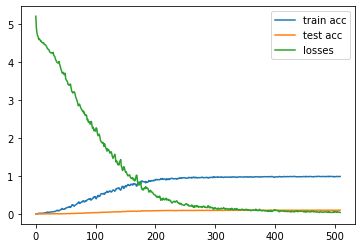

In [18]:
fig, ax = plt.subplots()
x = np.arange(len(losses)-1)
ax.plot(x, train_accs[:-1], label="train acc")
ax.plot(x, val_accs, label="test acc")
ax.plot(x, losses[:-1], label = "losses")
ax.legend()

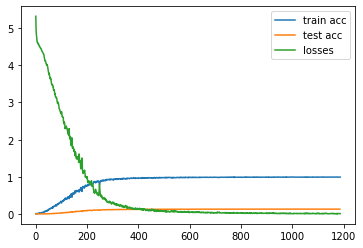

In [14]:
fig, ax = plt.subplots()
x = np.arange(len(losses))
ax.plot(x, train_accs, label="train acc")
ax.plot(x[:-1], val_accs, label="test acc")
ax.plot(x, losses, label = "losses")
ax.legend()

### Discussion

#### Bad singular value enforcement
* I'll space you the the graph but singular values normed to 1 could not learn
* We instead force to sqrt(N) where N is the size of the first householder matrix
    * This was learnable, but not small enough to force grokking
* In theory their could be a smarter way to enforce singular value rules

#### Slowness
* Treating every weight matrix as a product of orthognal matrices makes the model incredibly slow
    * Even if it was to work without huge improvements to the implementation it isn't reasonable
    * fasth the library mentioned earlier does implement it fairly well but it would cause even more memory issues

#### Theoretical understandings
* We can still learn mnist under strict rules on the singular values
* You do need a descent number of householder matrices such that you can learn any task
* It is hard to have good initialization values when the matrices are repersented by householder matrices
* More work can be put into better understanding good singular value rules to enforce such that you can force generalization - we still fundamentally believe in the idea

#### Further work
* The code should serve as a good basis for future work
* LinearSVD should probably take the norm value for the singular values
* Theoretically you could train a model to quicky overfit and then do a decomposition on the weights and train from their - this would be good for speed

#### Hypothesis testing
* Unfortunately results were never good enough to do a statistical test on - you would have to see improvement for that to make sense and the runtime just doesn't make that tenanble
